In [541]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from seaborn import heatmap
from fancyimpute import IterativeImputer
from random import randint

# Прогноз данных об одобрении кредита

Заказщик - финансовая организация, выдающая все виды кредитов. Нужно понять какие факторы влияют на платежеспособность клиента.

**Цели исследования:**
1) Влияет ли гендер на вероятность возврата кредита в срок?
2) Влияет ли семейное положение на вероятность возврата кредита в срок?
3) Влияет ли зарплата на вероятность возврата кредита в срок?
4) Влияет ли наличие образования на вероятность возврата кредита в срок?

**Ход исследования:**

Входные данные от банка — статистика о платёжеспособности клиентов — получены из файла data.csv. О качестве данных ничего не известно. Поэтому перед тем, как отвечать на вопрсоы исследования и делать вывод, понадобится обзор данных.
Проверим данные на ошибки и оценим их влияние на исследование. Затем, на этапе предобработки, поищем возможность исправить самые критичные ошибки данных.

После ответа на поставленные в исследовании вопросы, сделаем общией вывод.

Таким образом, исследование пройдёт в четыре этапа:

1) Обзор данных
2) Предобработка данных
3) Анализ данных и визуализация 
4) Общий вывод

## 1. Загрузка и обзор данных

In [542]:
# try:
#     data = pd.read_csv('/datasets/data.csv')
# except:
#     data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

# безопасней чиать файл так, но сначала нужно загрузить данные в облачное хранилище 

df = pd.read_csv('/home/angelina/Документы/ data_finance /train.csv')
df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


Удалим ненужные сотлбцы 

Loan_ID не несет никакой полезной информации, его можно удалить

In [543]:
# df = df.drop(columns='Load_ID')

Получим размер выборки

In [544]:
df.shape

(614, 13)

Получим основную информацию о дата сете

In [545]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [546]:
df.describe().applymap(lambda x: round(x, 2))

/tmp/ipykernel_12737/879548836.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.describe().applymap(lambda x: round(x, 2))


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.00,614.00,592.00,600.00,564.00
mean,5403.46,1621.25,146.41,342.00,0.84
std,6109.04,2926.25,85.59,65.12,0.36
min,150.00,0.00,9.00,12.00,0.00
25%,2877.50,0.00,100.00,360.00,1.00
50%,3812.50,1188.50,128.00,360.00,1.00
75%,5795.00,2297.25,168.00,360.00,1.00
max,81000.00,41667.00,700.00,480.00,1.00


## 2. Предобработка данных

###  2.1 Обработка пропусков 

Посмотрим сколько пропусков в данных есть для каждого столбца

In [547]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [548]:
df[df.isnull().sum(axis=1) >= 3]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
95,LP001326,Male,No,0,Graduate,NaN,6782,0.0,NaN,360.0,NaN,Urban,N
435,LP002393,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


In [549]:
df['Education'].value_counts(), df['Married'].value_counts(), df['Self_Employed'].value_counts(), df['Loan_Status'].value_counts(), df['Gender'].value_counts()


(Education
 Graduate        480
 Not Graduate    134
 Name: count, dtype: int64,
 Married
 Yes    398
 No     213
 Name: count, dtype: int64,
 Self_Employed
 No     500
 Yes     82
 Name: count, dtype: int64,
 Loan_Status
 Y    422
 N    192
 Name: count, dtype: int64,
 Gender
 Male      489
 Female    112
 Name: count, dtype: int64)

Можно заметить, что 5 колонок с категориальными признаками имеют только два значения. Можем изменить на значения 0 и 1, чтоб можено было провести корреляционный анализ, с помощью heatmap

In [550]:
df['Married'] = df['Married'].map({'Yes': 1, 'No': 0, 'Y': 1, 'N': 0})
df['Loan_Status'] = df['Loan_Status'].map({'Yes': 1, 'No': 0, 'Y': 1, 'N': 0})
df['Education'] = df['Education'].map({'Graduate': 1, 'Not Graduate': 0})
df['Self_Employed'] = df['Self_Employed'].map({'Yes': 1, 'No': 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1.0,0.0,0,1,0.0,5849,0.0,NaN,360.0,1.0,Urban,1
1,LP001003,1.0,1.0,1,1,0.0,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,1.0,1.0,0,1,1.0,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,1.0,1.0,0,0,0.0,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,1.0,0.0,0,1,0.0,6000,0.0,141.0,360.0,1.0,Urban,1


Посмотрим корреляцию данных, наша задача найти зависимости стобцов:
* Dependents, 
* Self_Employed, 
* LoanAmount,
* Loan_Amount_Term, 
* Credit_History,

с другими данными. Смотим именно на эти столбцы, так как в них большое количество отсутствующих значений важных для исследования 

<Axes: >

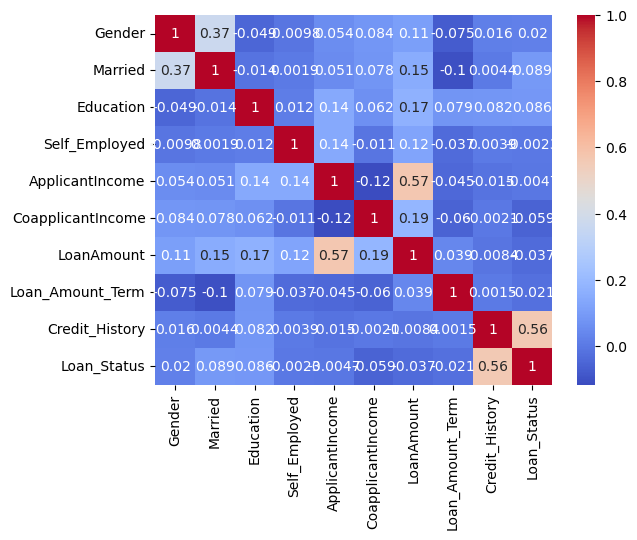

In [551]:
corr_df = df.corr(numeric_only=True)
heatmap(corr_df, annot=True, cmap='coolwarm')

Заполняем пропуски в данных необходимых для исследования 

Используем **IterativeImputer** для этих столбцов. **LoanAmount, Credit_History, Gender** имеют сильные корреляции с другими признаками, а **MICE**  хорошо работает с такими взаимосвязанными данными.

In [552]:
df.loc[:, ['LoanAmount', 'Credit_History', 'Gender']] = IterativeImputer().fit_transform(df.loc[:, ['LoanAmount', 'Credit_History', 'Gender']])

In [553]:
df.isna().sum()

Loan_ID               0
Gender                0
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

во всех данных, которые были небходимы для исследования, заполнены отсутствующие значения

### 2.3 Обработка дубликатов

In [554]:
df.duplicated().sum()

np.int64(0)

In [555]:
df = df.drop_duplicates()

In [556]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    float64
 2   Married            611 non-null    float64
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    int64  
 5   Self_Employed      582 non-null    float64
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    int64  
dtypes: float64(7), int64(3), object(3)
memory usage: 62.5+ KB


 ### 2.4 Обработка выбросов

Для обработки выбросов в столбце LoadAmount будем использовать правило трех сигм

In [557]:
mean_load = df['LoanAmount'].mean()
std_load = df['LoanAmount'].std()
data_outlier = df[(df['LoanAmount'] > (mean_load + 3*std_load)) | (df['LoanAmount'] < (mean_load - 3*std_load))] 
data_outlier['LoanAmount'], data_outlier.shape

(130    650.0
 155    600.0
 171    700.0
 177    495.0
 278    436.0
 308    480.0
 333    490.0
 369    570.0
 432    405.0
 487    500.0
 506    480.0
 523    480.0
 525    400.0
 561    600.0
 604    496.0
 Name: LoanAmount, dtype: float64,
 (15, 13))

* 0–100 — '0-100';
* 101–200 — '100-200';
* 201–300 — '200-300';
* 301–400 — '300-400';
* 401-500 — '400-500'.
* 501 и выше — '500-700'.

In [558]:
def categorize_income(income):
    try:
        if 0 <= income <= 100:
            return '0-100'
        elif 101 <= income <= 200:
            return '100-200'
        elif 201 <= income <= 300:
            return '200-300'
        elif 301 <= income <= 400:
            return '300-400'
        elif 401 <= income <= 500:
            return '400-500'
        elif 501 <= income <= 700:
            return '500-700'
    except:
        pass

In [559]:
df['LoanAmount_category'] = df['LoanAmount'].apply(categorize_income)

In [560]:
grop = df.groupby('LoanAmount_category')['Loan_ID'].count()

<Axes: xlabel='LoanAmount_category'>

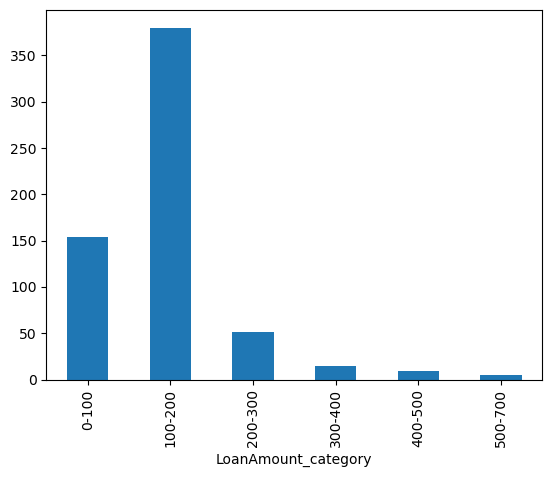

In [561]:
grop.plot(kind='bar', y='LoanAmount_category')

Зарплата 500-700 тысяч, хотя не подчиняется правилам трех сигм, не является выбросом 

## 3. Анализ и визуализация 

In [562]:
def depend_search(name):
    result = round(df.groupby(name)['Loan_Status'].mean(), 4)*100
    print('процент возврата кредита по котегориям')

    return result

def depend_visual(analis_name, name):
    analis_name.plot(kind='bar', x=name, color='#009B48')

### Визуализации процента возврата кредита по категориям зарплат 

In [563]:
analis_loanAmount = depend_search('LoanAmount_category')
analis_loanAmount

процент возврата кредита по котегориям


LoanAmount_category
0-100      69.48
100-200    70.00
200-300    62.75
300-400    46.67
400-500    66.67
500-700    80.00
Name: Loan_Status, dtype: float64

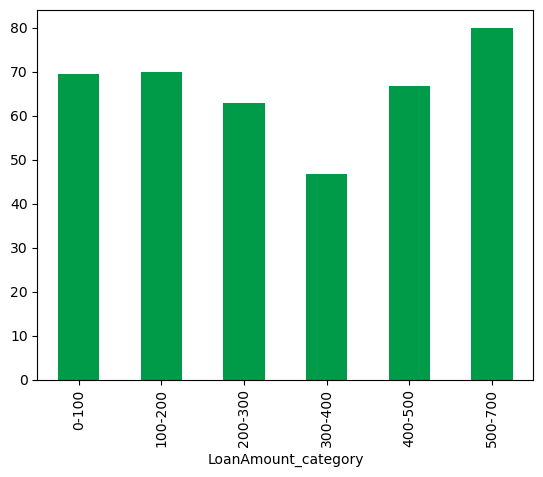

In [564]:
depend_visual(analis_name=analis_loanAmount, name='LoanAmount_category')

Можно увидеть, что заемщики с заработком более 500 тысяч (*80%*) чаще остальных возвращают кредит в срок. На втором месте по платежеспособности люди с заработком от 0 до 200 тысяч (*примерно 70%*).

При этом минимальные показатели оказались у группы с заработком от 300 до 400 (*менее 50%*)

### Визуализации процента возврата кредита в зависимости от семейного положения 

In [565]:
df['Married'] = df['Married'].map({1.0: 'married', 0.0: 'not married'})
analis_married = depend_search('Married')
analis_married

процент возврата кредита по котегориям


Married
married        71.61
not married    62.91
Name: Loan_Status, dtype: float64

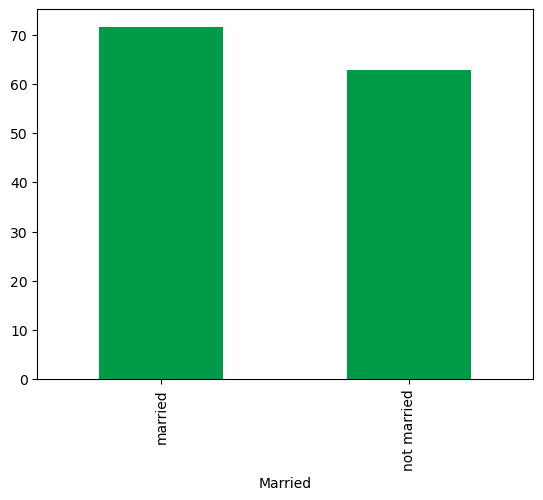

In [566]:
depend_visual(analis_name=analis_married, name='Married')

Заемщики состоящие в браке, вовремя закрывают кредит в среднем на **8%** чаще. 

Это может быть связано с тем, что люди вступившие в брак, обычно люди готовые и умеющие брать ответственность. Поэтому чаще своевременно закрывают долги.

### Визуализации процента возврата кредита в зависимости от гендера 

In [567]:
df['Gender'] = df['Gender'].map({1.0: 'man', 0.0: 'woman'})
analis_gender = depend_search('Gender')
analis_gender

процент возврата кредита по котегориям


Gender
man      69.33
woman    66.96
Name: Loan_Status, dtype: float64

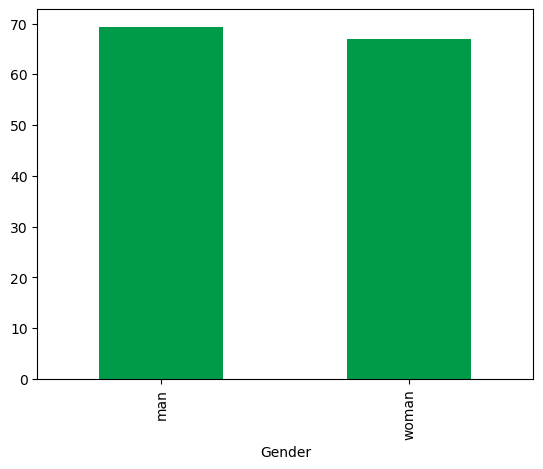

In [568]:
depend_visual(analis_name=analis_gender, name='Gender')

Разница между гендерами лежит в пределах статистической погрешности, **менее 3%** разницы. 

Закрытие кредита в срок не зависит от гендера.

### Визуализации процента возврата кредита в зависимости от образования

In [569]:
df['Education'] = df['Education'].map({1.0: 'Graduete', 0.0: 'Not Graduate'})
analis_education = depend_search('Education')
analis_education

процент возврата кредита по котегориям


Education
Graduete        70.83
Not Graduate    61.19
Name: Loan_Status, dtype: float64

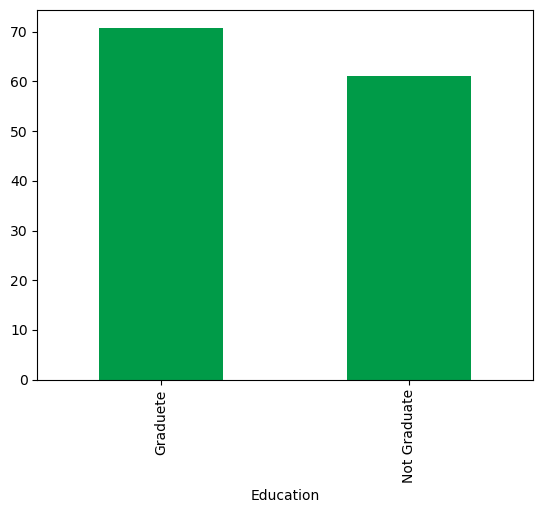

In [570]:
depend_visual(analis_name=analis_education, name='Education')

Заемщики, получившие образование почти на **10%** чаще закрывают кредит своевременно. 

Здесь может быть такая же логика как с браком, такие люди зачастую более ответственные, чем люди без образования.

### Визуализации процента возврата кредита по категориям кридитной истории 

In [571]:
def categorize_hitory(income):
    try:
        if 0 <= income <= 0.5:
            return '0-0.5'
        elif 0.5 < income <= 0.8:
            return '0.5-0.8'
        elif 0.8 < income <= 0.85:
            return '0.8-0.85'
        elif 0.85 < income <= 0.9:
            return '0.85-0.9'
        elif 0.9 < income <= 0.95:
            return '0.9-0.95'
        elif 0.95 < income <= 1:
            return '0.95-1'
    except:
        pass

In [572]:
df['Credit_History_ctegory'] = df['Credit_History'].apply(categorize_hitory)
analis_credit_history = depend_search('Credit_History_ctegory')
analis_credit_history

процент возврата кредита по котегориям


Credit_History_ctegory
0-0.5        7.87
0.8-0.85    74.00
0.95-1      79.58
Name: Loan_Status, dtype: float64

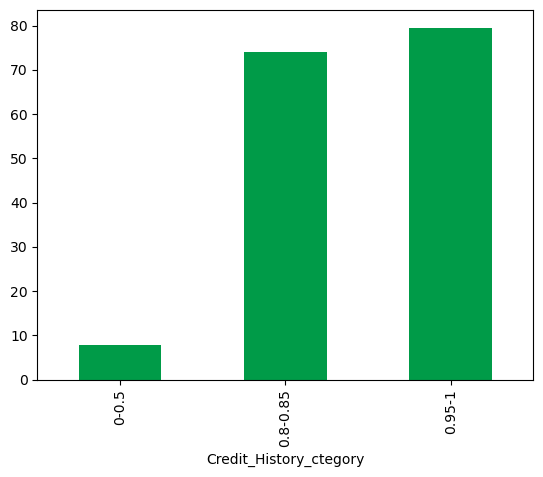

In [573]:
depend_visual(analis_name=analis_credit_history, name='Credit_History_ctegory')

In [574]:
df.groupby('Credit_History_ctegory')['Loan_Status'].count()

Credit_History_ctegory
0-0.5        89
0.8-0.85     50
0.95-1      475
Name: Loan_Status, dtype: int64

Здесь прослеживается явная зависимость кредитной истории, от  вероятности закрыть задолженность в срок. Заемщики с около нулевой кредитной историей почти на **70%** реже закрывают кредит в срок. 

Это может быть связано с тем, что люди берут кредит в первый раз и не могут точно оценить, какой ежемесечный платеж они смогут оплачивать. 

## 4. Ответы на исследовательские вопросы 

Ключевые факторы платёжеспособности:

* Наличие высшего образования (+9.64%)
* Состояние в браке (+8.7%)
* Высокий уровень дохода (особенно категория 500-700 тыс.)



Стоит обратить внимание на людей с зарплатой от 300 до 400 тысяч, проводить для них дополнительные проверки. А так же предусмореть кредитный лимит для заемщиков без кредитной истории. 